# Packages

In [114]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,roc_curve,auc
import tensorflow as tf
import random 
random.seed(10)

# Data

In [115]:
data = pd.read_csv("D:/Downloads/fraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [117]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [118]:
data.Time.describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

## Imbalanced data 

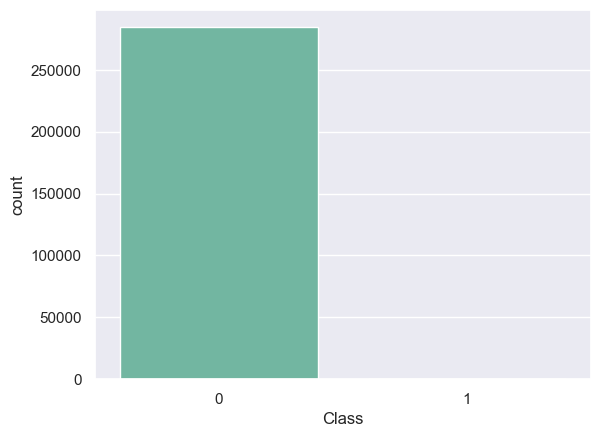

In [119]:
sns.countplot(x="Class",data=data,palette ="Set2");

# Preprocessing

## Splitting data

In [120]:
target = 'Class'
features = [x for x in list(data.columns) if x != target]
x_train,x_test,y_train,y_test = train_test_split(data[features],data[target],test_size=0.2,random_state=42)

## Normalizing variables

In [146]:
for i in ["Time","Amount"] :
    u = x_train[i].mean()
    sigma = x_train[i].std()
    x_train[i] = x_train[i].apply(lambda x : (x - u) / sigma)
    x_test[i] = x_test[i].apply(lambda x : (x - u) / sigma)


## Metrics

In [123]:
def metrics(model,x_test,y_test,conf_mat = False):
    test_preds = [x[0] for x in model.predict(x_test,verbose=0)]
    test_set_preds = [round(x[0]) for x in model.predict(x_test,verbose=0)]
    fpr, tpr, thresholds = roc_curve(y_test, test_preds)
    test_roc_auc = auc(fpr, tpr)
    j_scores = tpr - fpr
    best_threshold_idx = np.argmax(j_scores)
    j_index = j_scores[best_threshold_idx]
    best_threshold = thresholds[best_threshold_idx]
    cm = confusion_matrix(y_test,test_set_preds)
    metric = pd.DataFrame({"metric":["accuracy","roc_auc","sensitivity","specificity","precision","j_index"],
              "score":[accuracy_score(test_set_preds,y_test),test_roc_auc,recall_score(y_test,test_set_preds),
                       cm[0,0]/(cm[0,0]+cm[0,1]),precision_score(test_set_preds,y_test),j_index]})
    if conf_mat == True : 
        plt.figure(figsize=(2,2))
        sns.heatmap(cm, annot=True,fmt='d')
        plt.xlabel('Predicted_number')
        plt.ylabel('True_number')
    return metric
    

# First model imbalanced

In [124]:
model_0 = Sequential()
model_0.add(Dense(64, input_dim=len(features), activation='relu'))
model_0.add(Dense(1, activation='sigmoid'))

In [125]:
model_0.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy'])

In [126]:
history = model_0.fit(x_train, y_train, epochs=50, batch_size=100,verbose=0)

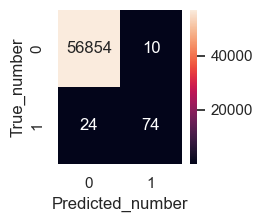

In [127]:
perf_one = metrics(model_0,x_test,y_test,True)

# Smote rebalaning

In [128]:
smote = SMOTE(sampling_strategy=0.85)
X_smote, y_smote = smote.fit_resample(x_train, y_train)

In [129]:
model_1 = Sequential()
model_1.add(Dense(64, input_dim=len(features), activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

In [130]:
model_1.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy'])

In [131]:
history = model_1.fit(X_smote, y_smote, epochs=50, batch_size=128,verbose=0)

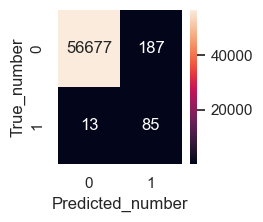

In [132]:
perf_two = metrics(model_1,x_test,y_test,True)

# Undersampling 

In [133]:
undersampler = RandomUnderSampler(random_state=42)
X_rus, y_rus = undersampler.fit_resample(x_train, y_train)

In [134]:
model_2 = Sequential()
model_2.add(Dense(64, input_dim=len(features), activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dense(1, activation='sigmoid'))

In [135]:
model_2.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [136]:
history = model_2.fit(X_rus, y_rus, epochs=100, batch_size=32,verbose=0)

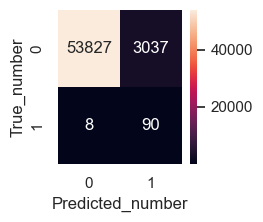

In [137]:
perf_three = metrics(model_2,x_test,y_test,True)

# Comparing results

In [145]:
print(f"model 1-------------------------------\n{perf_one}\nmodel 2-------------------------------\n{perf_two}\nmodel 3-------------------------------\n{perf_three}")

model 1-------------------------------
        metric     score
0     accuracy  0.999403
1      roc_auc  0.984891
2  sensitivity  0.755102
3  specificity  0.999824
4    precision  0.755102
5      j_index  0.898772
model 2-------------------------------
        metric     score
0     accuracy  0.996489
1      roc_auc  0.982105
2  sensitivity  0.867347
3  specificity  0.996711
4    precision  0.867347
5      j_index  0.888322
model 3-------------------------------
        metric     score
0     accuracy  0.946543
1      roc_auc  0.977233
2  sensitivity  0.918367
3  specificity  0.946592
4    precision  0.918367
5      j_index  0.884145
